In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import higher
import pickle

In [ ]:
def check_outpt(label, outpt, tol_neg, tol_pos):
    diff = label-outpt
    neg_acc = diff > tol_neg[None,None,:]
    pos_acc = diff < tol_pos[None,None,:]
    acc = neg_acc*pos_acc
    acc = acc.reshape(diff.size(0), -1)
    return torch.all(acc, dim=1)

In [ ]:
seq_len_global = 5

In [17]:

def make_toy_data(num_examples, inpt_func, outpt_func):
    generator =  torch.rand(num_examples)
    inpt = inpt_func(generator)
    outpt = outpt_func(inpt)
    return inpt, outpt

def check_outpt(label, outpt, tol_neg, tol_pos, window = 0):
    if window > 0:
        tol_neg, tol_pos, inpt= make_sliding_tol(label=inpt, neg_tol=tol_neg, pos_tol=tol_pos, window=window)

    diff = label-outpt

    if window > 0:
        neg_acc = diff > tol_neg
        pos_acc = diff < tol_pos
    else:
        neg_acc = diff > tol_neg[None,None,:]
        pos_acc = diff < tol_pos[None,None,:]
    acc = neg_acc*pos_acc
    acc = acc.reshape(diff.size(0), -1)
    return torch.all(acc, dim=1)

def make_tol(std_dev, dim, add=1e-3, device = 'cpu'):
    tol_neg = - (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    tol_pos = + (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    return tol_neg, tol_pos

def make_func(dim_in,dim_out, seq_len):
    seq_add = torch.arange(0,1,1/seq_len)
    tri = torch.randint(low=0, high=dim_in, size=(dim_out, dim_in))
    signs = torch.randint(low=-1, high=2, size=(dim_in*dim_out,)).reshape(dim_out, dim_in)

    tri = tri.reshape(-1).repeat(seq_len).reshape(1,-1)
    seq_counter = torch.arange(0, seq_len).reshape(1,-1).repeat([dim_in*dim_out, 1]).T.reshape(1,-1)
    tri = torch.cat((seq_counter, tri), dim=0)
    def inner_fc(inpt):
        n = len(inpt)
        tri_n = tri.repeat([1, n])
        n_counter = torch.arange(0, n).reshape(1,-1).repeat([dim_in*dim_out*seq_len, 1]).T.reshape(1,-1)
        tri_n = torch.cat((n_counter, tri_n), dim=0)
        seq_inpt = inpt[:,None, :] + seq_add[None,:,None]
        result = seq_inpt[tuple(tri_n)]
        result = result.reshape(n,seq_len, dim_out, dim_in)
        result = result*signs[None,None,:,:]
        result[(signs==0)[None,None,:,:].repeat([result.size(0), result.size(1),1,1])]=1
        result = torch.prod(result, dim=-1)
        return result
    return inner_fc

def plot_fcts(inpt, neg_tol, pos_tol, window = 0):
    inpt_dim = len(inpt[0])
    if window==0:
        neg_inpt = (inpt + neg_tol[None,:]).numpy()
        pos_inpt = (inpt + pos_tol[None,:]).numpy()
    else:
        sliding_tol_pos, sliding_tol_neg, inpt= make_sliding_tol(label=inpt.unsqueeze(0), neg_tol=neg_tol, pos_tol=pos_tol, window=window)
        pos_inpt, neg_inpt = sliding_tol_pos.numpy(), sliding_tol_neg.numpy()
        inpt = inpt[0]

    np_inpt = inpt.numpy()
    print(f'input: {np_inpt.shape}')
    
    seq_len = len(inpt)
    num_graphs = int(np.ceil(np.sqrt(inpt_dim)))
    fig, ax = plt.subplots(num_graphs,num_graphs)
    fig.set_size_inches(9, 9)
    for sp in range(inpt_dim):
        idx = sp // num_graphs
        idy = sp  % num_graphs
        ax[idx,idy].clear()
        ax[idx,idy].plot(range(seq_len), np_inpt[:,sp], alpha=0.5, color='midnightblue')
        ax[idx,idy].plot(range(seq_len), neg_inpt[:,sp], alpha=0.5, color='orangered')
        ax[idx,idy].plot(range(seq_len), pos_inpt[:,sp], alpha=0.5, color='orangered')

def save(path, dict):
    if not os.path.exists(path):
        os.makedirs(path)

    for dk, data in dict.items():
        tdata = data
        torch.save(tdata, path + str(dk))

def make_toy_data(fct, n, dim_in, std = 0.1, data_path= None):
    inpt = torch.normal(mean=torch.zeros([n,1, dim_in]), std=std*torch.ones([n,1,dim_in]))
    print(inpt.max())
    print(inpt.min())
    label = fct(inpt[:,0])
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    mean_label = tl.mean(dim=1)
    label = label - mean_label
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    tmax = tl[:10].max(dim=1)[0]
    tmin = tl[:10].min(dim=1)[0]
    rel_corr = tmax - tmin
    label = label % 1

    data_sets = ['train', 'val', 'test']
    if path is not None:
        for i, set in enumerate(data_sets):
            path =  data_path + set + '/'
            start = i * int(len(inpt)/len(data_sets))
            end = (i+1) * int(len(inpt)/len(data_sets))
            print(start)
            print(end)
            save(path=path, dict={'inpt':5*inpt[start:end], 'label':label[start:end]})
    return inpt, label

def make_sliding_tol_dim(label, window = 9, pos = True):
    batch_size = label.size(0)
    batch_counter = torch.arange(batch_size)
    counter = torch.arange(label.size(-1) - window) + int(window/2)
    window_counter = torch.arange(window) - int(window/2)
    s_ind = counter.repeat([batch_size,window,1]).transpose(-1,-2)
    f_ind = (counter[:,None] + window_counter[None,:]).repeat([batch_size, 1,1])
    batch_ind = batch_counter.reshape(-1,1,1).repeat([1,f_ind.size(-2), f_ind.size(-1)])
    ind = tuple((batch_ind, f_ind, s_ind))
    label_repeated = label.unsqueeze(-1).repeat([1,1,label.size(-1)])
    label_ind = label_repeated[ind]
    result = label_ind.max(dim=-1)[0], label_ind.min(dim=-1)[0]
    return result

def make_sliding_tol(label, neg_tol, pos_tol, window=9):
    tols_pos, tols_neg = [], []
    for dim in range(label.size(-1)):
        tol_pos, tol_neg = make_sliding_tol_dim(label=label[:,:,dim], window=window)
        tols_pos.append(tol_pos.unsqueeze(-1))
        tols_neg.append(tol_neg.unsqueeze(-1))
    sliding_tol_pos, sliding_tol_neg = torch.cat(tuple(tols_pos), dim=-1), torch.cat(tuple(tols_neg), dim=-1)
    neg_inpt = (sliding_tol_neg[0] + neg_tol[None,:])
    pos_inpt = (sliding_tol_pos[0] + pos_tol[None,:])
    inpt = label[:, int(window/2):-(int(window/2) + 1)]
    result = pos_inpt, neg_inpt, inpt
    return result

In [ ]:
inner_fct = make_func(dim_in=4, dim_out=4, seq_len=seq_len_global)


In [ ]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=5e-2)
a= (neg, pos)
path_to_file = '/home/hendrik/Documents/master_project/LokalData/metaworld/test/toy_data/tol/'
from os import path, makedirs
#dir_path = path.dirname(path.realpath(__file__))
if not path.exists(path_to_file):
    makedirs(path_to_file)
with open(path_to_file + 'tol.pkl', 'wb') as f:
    pickle.dump(a, f)  



In [ ]:
with open(path_to_file + 'tol.pkl', 'rb') as f:
    b = pickle.load(f)

In [ ]:
inpt, label = make_toy_data(inner_fct, n=30000, dim_in=4, std=0.1, data_path='/home/hendrik/Documents/master_project/LokalData/metaworld/small/')
outpt = torch.clone(label)
outpt[0,0,0] = 20
#print(check_outpt(label=inpt, outpt=outpt, tol_neg=neg, tol_pos=pos))
#make_func(2,3,torch.tensor([1,2]))

input: (5, 4)


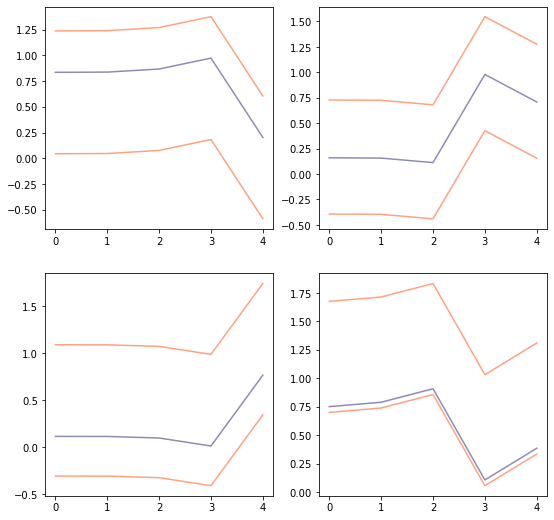

In [19]:
plot_fcts(inpt=label[0], neg_tol=neg, pos_tol=pos)

In [ ]:
neg = 0.1*-torch.ones(label.size(-1))
pos = 0.1*torch.ones(label.size(-1))
plot_fcts(label[0], neg, pos, window=9)

In [ ]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=1e-3)


In [ ]:
c1d = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=51, padding='same', padding_mode='reflect')
c1d.bias = torch.nn.Parameter(torch.zeros_like(c1d.bias))
c1d.weight = torch.nn.Parameter(1/51 * torch.ones_like(c1d.weight))

In [ ]:
label[:1,:,:1].shape

In [ ]:
convout1 = c1d(label[:1,:,:1].transpose(1,2)).detach()
convout2 = c1d(label[:1,:,1:2].transpose(1,2)).detach()
convout = torch.cat((convout1, convout2), dim=1)

In [ ]:
neg = label[:1,:,:2] - convout.transpose(1,2) - 0.1

In [ ]:
plot_fcts(inpt=label[2,4:-5], neg_tol=sliding_window[2], pos_tol=sliding_window[1])


In [ ]:
t1 = torch.arange(10)

In [ ]:
def make_sliding_tol_dim(label, window = 9, pos = True):
    batch_size = label.size(0)
    batch_counter = torch.arange(batch_size)
    counter = torch.arange(label.size(-1) - window) + int(window/2)
    window_counter = torch.arange(window) - int(window/2)
    s_ind = counter.repeat([batch_size,window,1]).transpose(-1,-2)
    f_ind = (counter[:,None] + window_counter[None,:]).repeat([batch_size, 1,1])
    batch_ind = batch_counter.reshape(-1,1,1).repeat([1,f_ind.size(-2), f_ind.size(-1)])
    ind = tuple((batch_ind, f_ind, s_ind))
    label_repeated = label.unsqueeze(-1).repeat([1,1,label.size(-1)])
    label_ind = label_repeated[ind]
    result = label_ind.max(dim=-1)[0], label_ind.min(dim=-1)[0]
    return result

def make_sliding_tol(label, neg_tol, pos_tol, window=9):
    tols_pos, tols_neg = [], []
    for dim in range(label.size(-1)):
        tol_pos, tol_neg = make_sliding_tol_dim(label=label[:,:,dim], window=window)
        tols_pos.append(tol_pos.unsqueeze(-1))
        tols_neg.append(tol_neg.unsqueeze(-1))
    sliding_tol_pos, sliding_tol_neg = torch.cat(tuple(tols_pos), dim=-1), torch.cat(tuple(tols_neg), dim=-1)
    neg_inpt = (sliding_tol_neg[0] + neg_tol[None,:])
    pos_inpt = (sliding_tol_pos[0] + pos_tol[None,:])
    inpt = label[:, int(window/2):-(int(window/2) + 1)]
    result = pos_inpt, neg_inpt, inpt
    return result

In [ ]:
sliding_window, a = make_sliding_tol(label=label[:10])
print(sliding_window.shape)

In [ ]:
tol0 = make_sliding_tol(label=label[:,:,0])[0]
tol1 = make_sliding_tol(label=label[:,:,1])[0]


In [ ]:
tol = torch.cat((tol0.unsqueeze(-1), tol1.unsqueeze(-1)), dim=-1)

In [ ]:
tol.shape

In [ ]:
counter = torch.arange(8) + 1
ccounter = torch.arange(3) - 1
s_ind = counter[:,None] + ccounter[None,:]
f_ind = counter.repeat([3,1]).transpose(0,1) - 1
ind = tuple((f_ind, s_ind))

In [ ]:
ind

In [ ]:
tr = t1.repeat([10,1])

In [ ]:
tr.shape

In [ ]:
tr.reshape(10,2,10)

In [ ]:
result = tr[ind]

In [ ]:
result

In [ ]:
label.shape

In [ ]:
neg.shape

In [ ]:
from torch.utils.data import DataLoader

class TorchDatasetMW(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data):
      self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.data[index]

In [ ]:
data = torch.arange(10)
dataset = TorchDatasetMW(data)

In [ ]:
len(dataset)

In [ ]:
random_indices = torch.randperm(10)[:5]
trainset_1 = torch.utils.data.Subset(dataset, random_indices)

In [ ]:
loader = DataLoader(trainset_1)
for a in loader:
    print(a)

In [ ]:
a = torch.arange(5)

In [ ]:
a[random_indices]